In [46]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
from skimage import io as skio
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from skimage import io
import cv2 as cv
import os
import shutil
import base64
import json
import skimage.io as skio
import io
import torchvision.models as models
import time
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from tabulate import tabulate

In [47]:
#File path to the weights file
checkpoint_path = "/home/group18/Final/Final_Model/Final_Weights.pth.tar"

In [48]:
#Creates Dataset form MIMIC images
class MIMIC_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        #Retrieves image name from mimic dataset csv
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = skio.imread(img_path + ".jpg")
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))

        results = []

        # Atelectasis
        results.append(int(self.annotations.iloc[index, 12] == 1.0))

        # Cardiomegaly
        results.append(int(self.annotations.iloc[index, 13] == 1.0))

        # Consolidation
        results.append(int(self.annotations.iloc[index, 14] == 1.0))

        # Edema
        results.append(int(self.annotations.iloc[index, 15] == 1.0))

        # No Finding
        results.append(int(self.annotations.iloc[index, 20] == 1.0))

        # Pleural Effusion
        results.append(int(self.annotations.iloc[index, 21] == 1.0))

        y_label = torch.tensor(results, dtype=torch.float32)

        if self.transform:
            new_image = self.transform(new_image)

        return new_image, y_label

In [49]:
#Overalys mask on image used for Grad Cam
def show_cam_on_image(img, mask, use_rgb=True, alpha=0.5):
    # Convert mask to a heatmap
    heatmap = cv.applyColorMap(np.uint8(255 * mask), cv.COLORMAP_JET)
    if use_rgb:
        heatmap = cv.cvtColor(heatmap, cv.COLOR_BGR2RGB)
        img = cv.cvtColor(np.uint8(255 * img), cv.COLOR_BGR2RGB)
    else:
        img = np.uint8(255 * img)
    # Blend the heatmap with the original image
    overlayed_img = cv.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlayed_img


In [50]:
#Creates the densenet model for the given number of classes
def create_densenet121(num_classes):
    # Load the DenseNet121 model without pre-trained weights
    model = models.densenet121(weights=None)
    
    # Modify the last fully connected layer to have the output features equal to the number of classes
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    
    return model

#Function used to create a Grad-Cam image for a specific disease 
def generate_gradcam(model, input_tensor, original_image, target_category=None):
    
    #target_layers = model.features.denseblock4.denselayer16.conv2 #previously used layer
    target_layers = model.features[-1]
    
    # Initialize Grad-CAM with the specified target layers
    cam = GradCAM(model=model, target_layers=[target_layers])  # Encapsulate target_layers in a list
    
    # Define targets based on the specified target category
    targets = [ClassifierOutputTarget(target_category)] if target_category is not None else None
    
    # Generate CAM mask
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Create visualization with the specified alpha for the overlay transparency
    visualization = show_cam_on_image(np.array(original_image) / 255.0, grayscale_cam, use_rgb=True, alpha=0.3)

    return visualization



In [51]:
# Function to load checkpoint
def load_checkpoint(model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()  # Set the model to evaluation mode
    print(f"Checkpoint loaded from '{checkpoint_path}'")
    return model, optimizer

In [52]:
# Function to save checkpoint
def save_checkpoint(model, optimizer):
    checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to '{checkpoint_path}'")

In [53]:
#Server has of 4 GPU, manually set to avoid multiple models going to same GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # Specify which GPU to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [54]:
# Model Training

def train_model(train_loader, n_epochs, loadModel, learning_rate):

    #creates an instance of the densenet 121 model for 6 classes
    model = create_densenet121(6).to(device)

    #defines optimizer using Adam optimizer
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Load checkpoint if specified
    if loadModel:
        model, opt = load_checkpoint(model, opt)
        opt.param_groups[0]['lr'] = learning_rate

    #loss function
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss() 

    model.train()  # Set the model to training mode

    losses = []
    epochs = []

    print("model parameters: ", next(model.parameters()).device)

    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(train_loader)
        epoch_losses = []
        for batch_index, (image, targets) in enumerate(train_loader):
            image, targets = image.to(device), targets.to(device)
            opt.zero_grad()
            outputs = model(image)
            loss_value = criterion(outputs, targets)

            loss_value.backward()
            opt.step()

            epochs.append(epoch + batch_index / N)
            losses.append(loss_value.item())
            epoch_losses.append(loss_value.item())

            # Release GPU memory
            torch.cuda.empty_cache()

        average_loss = np.mean(epoch_losses)
        print(f'Average Loss for Epoch {epoch}: {average_loss}')

        # Save checkpoint after each epoch
        save_checkpoint(model, opt)

    return model, np.array(epochs), np.array(losses)

In [55]:
#Computes performance metrics for each disease
#Metrics include AUC, f1, precision, recall and prints ROC
#It also produces the optimal thresholds

def analyze_model(data_loader, model):
    diseaseNames = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "No Finding", "Pleural Effusion"]
    bestThresholds = []

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predicted_probs.append(probabilities.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    predicted_probs = np.concatenate(predicted_probs)
    true_labels = np.concatenate(true_labels)

    if np.any(np.isnan(true_labels)):
        print("True labels contain NaN values.")
        true_labels[np.isnan(true_labels)] = 0

    plt.figure(figsize=(10, 8))

    for i in range(len(diseaseNames)):
        binary_true_labels = true_labels[:, i]
        pred_probs_i = predicted_probs[:, i].flatten()

        if len(pred_probs_i) != len(binary_true_labels):
            raise ValueError("Mismatch in dimensions between predicted probabilities and true labels.")

        fpr, tpr, thresholds = roc_curve(binary_true_labels, pred_probs_i)
        roc_auc = auc(fpr, tpr)
        best_threshold_index = np.argmax(tpr - fpr)
        best_threshold = thresholds[best_threshold_index]
        bestThresholds.append(best_threshold)

        binary_predictions = (pred_probs_i > best_threshold).astype(int)
        precision = precision_score(binary_true_labels, binary_predictions)
        recall = recall_score(binary_true_labels, binary_predictions)
        f1 = f1_score(binary_true_labels, binary_predictions)

        # Plot ROC curve for each disease
        plt.plot(fpr, tpr, lw=2, label=f'{diseaseNames[i]} (AUC = {roc_auc:.2f})')

        print(f"{diseaseNames[i]}:")
        print(f"   AUC: {roc_auc:.4f}")
        print(f"   Best Threshold: {best_threshold:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1 Score: {f1:.4f}\n")

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return bestThresholds

In [56]:
#This block of code is used for training our model
#The learnig rates were determined by running multiple instances (1-3)
#of our model using different learning rates keeping whichever weights perfomed best

# Start Model Training


# csv_file_path = "/home/group18/Data/mimic/csv/train/p10.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p10"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=False, learning_rate=0.001)



# csv_file_path = "/home/group18/Data/mimic/csv/train/p11.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p11"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.001)



# csv_file_path = "/home/group18/Data/mimic/csv/train/p12.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p12"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.00005)

# copy_name = "p10-p12_0.00005.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate/" + copy_name)

# file_path = "/home/group18/test/done.txt"  

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name + "\n")





# csv_file_path = "/home/group18/Data/mimic/csv/train/p13.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p13"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.00001)

# copy_name = "p10-p13_0.00001.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
# #     file.write(copy_name  + "\n")




# csv_file_path = "/home/group18/Data/mimic/csv/train/p14.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p14"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.00001)

# copy_name = "p10-p14_0.00001.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate/" + copy_name)

# file_path = "/home/group18/test/done.txt"  

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name + "\n")




# csv_file_path = "/home/group18/Data/mimic/csv/train/p15.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p15"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.00001)

# copy_name = "p10-p15_0.00001.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")








# csv_file_path = "/home/group18/Data/mimic/csv/train/p16.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p16"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.00001)

# copy_name = "p10-p16_0.00001.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")





#Pass 2




# csv_file_path = "/home/group18/Data/mimic/csv/train/p10.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p10"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.00001)

# copy_name = "pass2_p10-p10_0.00001.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")




# csv_file_path = "/home/group18/Data/mimic/csv/train/p11.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p11"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.0000005)

# copy_name = "pass_2_p10-p11_0.0000005.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate_2/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")






# csv_file_path = "/home/group18/Data/mimic/csv/train/p12.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p12"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.000005)

# copy_name = "pass_2_p10-p12_0.000005.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate_2/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")





# csv_file_path = "/home/group18/Data/mimic/csv/train/p13.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p13"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.000005)

# copy_name = "pass_2_p10-p13_0.000005.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate_2/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")





# csv_file_path = "/home/group18/Data/mimic/csv/train/p14.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p14"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.000005)

# copy_name = "pass_2_p10-p14_0.000005.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate_2/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")





# csv_file_path = "/home/group18/Data/mimic/csv/train/p15.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p15"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.000005)

# copy_name = "pass_2_p10-p15_0.000005.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate_2/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")





# csv_file_path = "/home/group18/Data/mimic/csv/train/p16.csv"
# root_dir_path = "/home/group18/Data/mimic/train/p16"

# train_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
# train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True, pin_memory=True)

# model, epoch_data, loss_data = train_model(train_loader, n_epochs=10, loadModel=True, learning_rate=0.000005)

# copy_name = "pass_2_p10-p16_0.000005.pth.tar"
# shutil.copy(checkpoint_path, "/home/group18/Final/Saved_Models_Learning_Rate_2/" + copy_name)

# # Open the file in append mode
# with open("/home/group18/Final/Model_Code/learning_finished.txt", "a") as file:
#     # Append text to the end of the file
#     file.write(copy_name  + "\n")

In [57]:
# Load Validation Set

# csv_file_path =  "/home/group18/Data/mimic/csv/validation/p17.csv"
# root_dir_path = "/home/group18/Data/mimic/validation/p17"

#Paths for Testing
#Folders p18 and p18 must be combined before running
csv_file_path =  "/home/group18/Data/mimic/csv/test/p18_p19.csv"
root_dir_path = "/home/group18/Data/mimic/test/p18_p19"

data_set = MIMIC_Dataset(csv_file=csv_file_path, root_dir=root_dir_path, transform=transforms.ToTensor())
data_loader = DataLoader(dataset=data_set, batch_size=64, shuffle=True)

In [58]:
# Run Model Validation/Testing

# model = create_densenet121(6)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loaded_model, loaded_optimizer = load_checkpoint(model, optimizer)
# loaded_model.eval()
# loaded_model.to(device)

# analyze_model(data_loader, model)

In [59]:
#Runs our model on a single image and returns disease prediction, true labels and grad cam images


def test_single_image(filepath, csv_file_path, thresholds, model, device):
    # Read and preprocess the image
    image = cv.imread(filepath)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    original_image = Image.fromarray(image)
    original_image = original_image.resize((256, 256))

    # Convert the image to a PyTorch tensor and enable gradient
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(original_image).unsqueeze(0).requires_grad_(True)
    image_tensor = image_tensor.to(device)

    # Ensures the model is on the correct device and set it to training mode temporarily
    model = model.to(device)

    prediction = []
    true_labels = []
    grad_cam_image = []

    # Perform forward pass to get predictions and the last convolutional layer's activations
    with torch.enable_grad():  # Ensure gradients are computed
        outputs = model(image_tensor)
        probability = torch.sigmoid(outputs).detach().cpu().numpy()

        # Generate Grad-CAM for the highest scoring category
        _, target_category = torch.max(outputs, 1)

        for x in range (0,6):
            grad_cam_image.append(generate_gradcam(model,image_tensor, original_image, target_category=x))
        
    # Extract true labels from CSV file
    filename_without_extension = os.path.splitext(os.path.basename(filepath))[0]
    with open(csv_file_path, 'r') as f:
        datareader = csv.reader(f)
        for row in datareader:
            if row[0] == filename_without_extension:
                true_labels.extend([int(float(row[i])) if row[i] == '1.0' else 0 for i in [12, 13, 14, 15, 20, 21]])
                subject = row[1]
                study = row[2]
                break

    # Compare predictions and true labels
    for i in range(6):
        prediction.append(1 if probability[0][i] >= thresholds[i] else 0)

    print("probability: ", probability)
    print("prediction: ", prediction)
    print("true lables: ", true_labels)

    print("\n\n")

    print ("subject id", subject)
    print("study id", study)

    # Create a table for visualization
    array1 = ['Atelectasis', probability[0][0], prediction[0], true_labels[0]]
    array2 = ['Cardiomegaly', probability[0][1], prediction[1], true_labels[1]]
    array3 = ['Consolidation', probability[0][2], prediction[2], true_labels[2]]
    array4 = ['Edema', probability[0][3], prediction[3], true_labels[3]]
    array5 = ['No Finding', probability[0][4], prediction[4], true_labels[4]]
    array6 = ['Pleural Effusion', probability[0][5], prediction[5], true_labels[5]]

    table = [['Disease', 'Model Output', 'Model Prediction', 'True Labels'],
             array1, array2, array3, array4, array5, array6]

    # Print the table
    print("\n")
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

    return original_image, grad_cam_image, prediction


In [60]:
#Runs our model on a single image and returns disease prediction and grad cam images

def test_single_image_no_csv(filepath, thresholds, model, device):
    # Read and preprocess the image
    image = cv.imread(filepath)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    original_image = Image.fromarray(image)
    original_image = original_image.resize((256, 256))

    # Convert the image to a PyTorch tensor and enable gradient
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(original_image).unsqueeze(0).requires_grad_(True)
    image_tensor = image_tensor.to(device)

    model = model.to(device)
    
    prediction = []
    grad_cam_image = []

    # Perform forward pass to get predictions and the last convolutional layer's activations
    with torch.enable_grad():  # Ensure gradients are computed
        outputs = model(image_tensor)
        probability = torch.sigmoid(outputs).detach().cpu().numpy()

        # Generate Grad-CAM for the highest scoring category
        _, target_category = torch.max(outputs, 1)

        for x in range (0,6):
            grad_cam_image.append(generate_gradcam(model,image_tensor, original_image, target_category=x))
    
    # Compare predictions and true labels
    for i in range(6):
        prediction.append(1 if probability[0][i] >= thresholds[i] else 0)

    print("probability: ", probability)
    print("prediction: ", prediction)

    # Create a table for visualization
    array1 = ['Atelectasis', probability[0][0], prediction[0]]
    array2 = ['Cardiomegaly', probability[0][1], prediction[1]]
    array3 = ['Consolidation', probability[0][2], prediction[2]]
    array4 = ['Edema', probability[0][3], prediction[3]]
    array5 = ['No Finding', probability[0][4], prediction[4]]
    array6 = ['Pleural Effusion', probability[0][5], prediction[5]]

    table = [['Disease', 'Model Output', 'Model Prediction'],
             array1, array2, array3, array4, array5, array6]

    # Print the table
    print("\n")
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

    return original_image, grad_cam_image, prediction


In [61]:
#Plots original and grad cam image side by side for easy comparison

def plot_images(original_image, grad_cam_image, diseaseName):
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')  # Hide the axes ticks

    # Plot the Grad-CAM heatmap
    axs[1].imshow(grad_cam_image)
    axs[1].set_title('Grad-CAM Heatmap for ' + diseaseName)
    axs[1].axis('off')  # Hide the axes ticks

    # Display the plot
    plt.show()

In [62]:
#These functions are shared between backend and frontend and are used to convert images to byte array so they can be passed in a json


#Converts JPG image to RGB and resizes
def jpg256(jpg_path):
        image = skio.imread(jpg_path)
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))
        return new_image

#Converts jpg images to tensor
def Tensor256(jpg_path):
        image = skio.imread(jpg_path)
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))

        to_tensor = transforms.ToTensor()
        image_tensor = to_tensor(new_image)
        return image_tensor


#Converts an image to RGB and resizes then converts to tensor
def Grad_Tensor256(jpg_path,device):
        image = skio.imread(jpg_path)
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))

        to_tensor = transforms.ToTensor()
        new_image =  to_tensor(new_image).unsqueeze(0).requires_grad_(True)
        image_tensor = image_tensor.to(device)
        return to_tensor


#converts JPEG to a byte representation
def image_to_base64(image_array):
        image = Image.fromarray(np.uint8(image_array)).convert('RGB')
        img_byte_arr = io.BytesIO()
        image.save(img_byte_arr, format='JPEG')
        return base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')


# Function to preprocess and convert image to byte array
def preprocess_and_convert_to_byte_array(image_path):
        # Preprocess the image
        image = skio.imread(image_path)
        RGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        new_image = Image.fromarray(RGB)
        new_image = new_image.resize((256, 256))

        # Convert to byte array
        img_byte_arr = io.BytesIO()
        new_image.save(img_byte_arr, format='JPEG')
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr

# Function to convert byte array back to image
def byte_array_to_image(byte_array):
        img_byte_arr = io.BytesIO(byte_array)
        img = Image.open(img_byte_arr)
        return img


In [63]:
#Runs our model on a single image and returns disease prediction, true labels and grad cam images
#Then prints and plots results

def run_with_csv(filepath, csv_filepath):

    model = create_densenet121(6)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    loaded_model, loaded_optimizer = load_checkpoint(model, optimizer)
    loaded_model.eval()
    loaded_model.to(device)

    #thresholds are old and determine if model predictions are 1 or 0 based on model probability
    thresholds = [0.17107886, 0.15799165, 0.03852078, 0.09797211, 0.3499906, 0.1622753]

    diseaseNames = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "No Finding", "Pleural Effusion"]

    print("thresholds: ", thresholds)

    original_image, grad_cam_image, predictions = test_single_image(filepath, csv_filepath, thresholds, loaded_model, device)

    for x in range(0,6):
        plot_images(original_image, grad_cam_image[x], diseaseNames[x])

    grad_cam_images_base64 = [image_to_base64(img) for img in grad_cam_image]

    diseases_data = []
    for i, disease_name in enumerate(diseaseNames):
        diseases_data.append({
            "diseaseName": disease_name,
            "prediction": predictions[i],
            "gradCamImage": grad_cam_images_base64[i]
        })

    data = { "diseasesData": diseases_data }

    # Convert the structured data to a JSON string
    json_data = json.dumps(data, indent=4)

    return json_data



In [64]:
#Runs our model on a single image and returns disease prediction and grad cam images
#Then prints and plots results

def run_with_no_csv(filepath):

    model = create_densenet121(6)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    loaded_model, loaded_optimizer = load_checkpoint(model, optimizer)
    loaded_model.eval()
    loaded_model.to(device)

    #thresholds are old and determine if model predictions are 1 or 0 based on model probability
    thresholds = [0.17107886, 0.15799165, 0.03852078, 0.09797211, 0.3499906, 0.1622753]

    diseaseNames = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "No Finding", "Pleural Effusion"]

    print("thresholds: ", thresholds)

    original_image, grad_cam_image, predictions = test_single_image_no_csv(filepath, thresholds, loaded_model, device)

    for x in range(0,6):
        plot_images(original_image, grad_cam_image[x], diseaseNames[x])


    grad_cam_images_base64 = [image_to_base64(img) for img in grad_cam_image]

    diseases_data = []
    for i, disease_name in enumerate(diseaseNames):
        diseases_data.append({
            "diseaseName": disease_name,
            "prediction": predictions[i],
            "gradCamImage": grad_cam_images_base64[i]
        })

    data = { "diseasesData": diseases_data }

    # Convert the structured data to a JSON string
    json_data = json.dumps(data, indent=4)

    return json_data


Checkpoint loaded from '/home/group18/Final/Final_Model/Final_Weights.pth.tar'
thresholds:  [0.17107886, 0.15799165, 0.03852078, 0.09797211, 0.3499906, 0.1622753]
probability:  [[0.22808503 0.55124533 0.06809225 0.40411648 0.08058737 0.26799962]]
prediction:  [1, 1, 1, 1, 0, 1]
true lables:  [1, 0, 0, 0, 0, 1]



subject id 18042178
study id 55414081


╒══════════════════╤════════════════╤════════════════════╤═══════════════╕
│ Disease          │   Model Output │   Model Prediction │   True Labels │
╞══════════════════╪════════════════╪════════════════════╪═══════════════╡
│ Atelectasis      │      0.228085  │                  1 │             1 │
├──────────────────┼────────────────┼────────────────────┼───────────────┤
│ Cardiomegaly     │      0.551245  │                  1 │             0 │
├──────────────────┼────────────────┼────────────────────┼───────────────┤
│ Consolidation    │      0.0680922 │                  1 │             0 │
├──────────────────┼────────────────┼────────

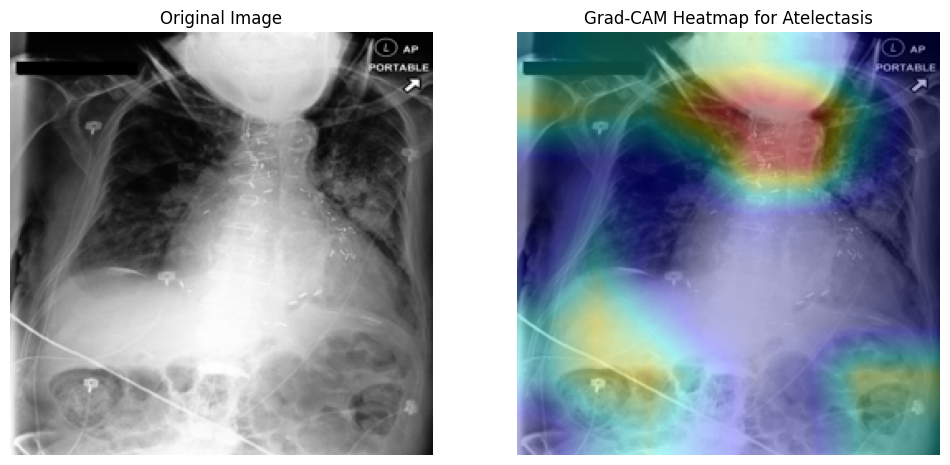

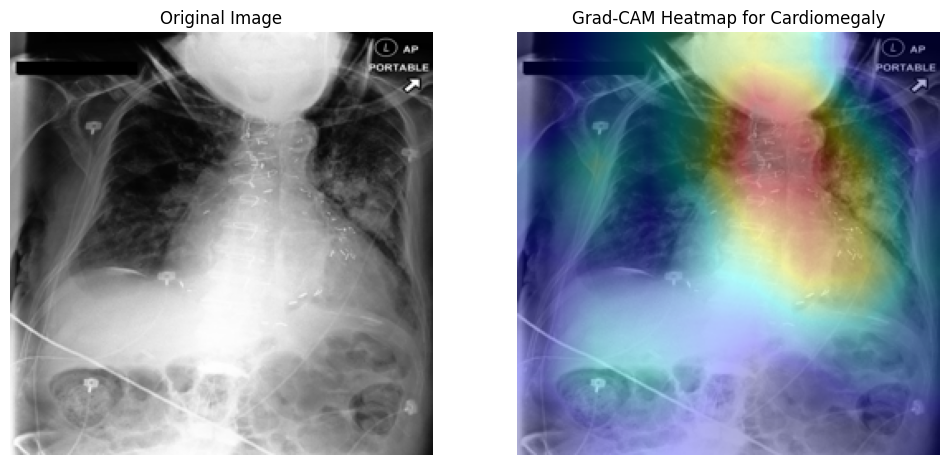

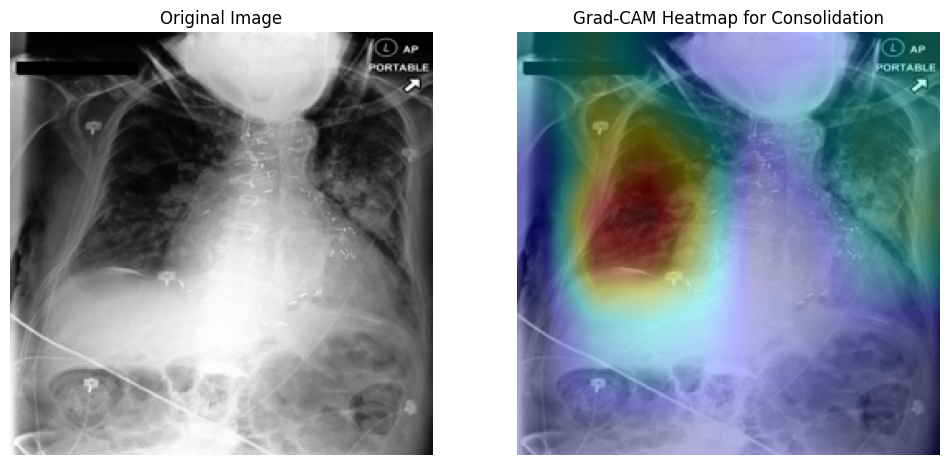

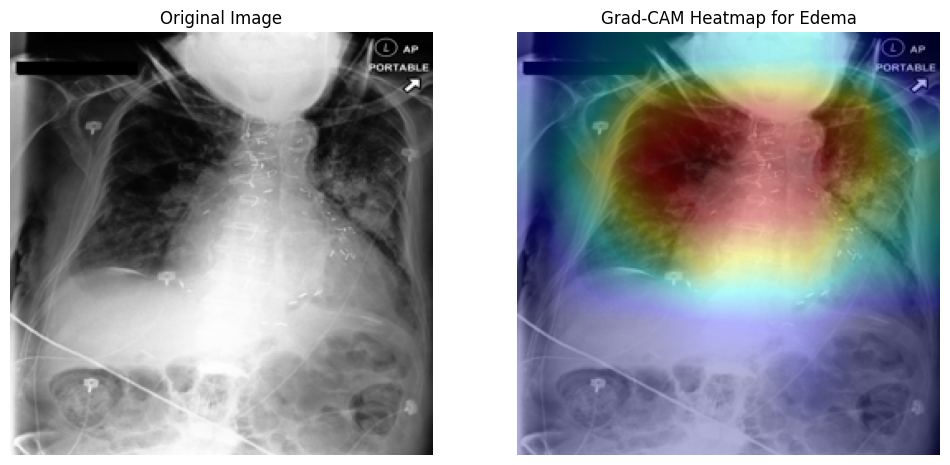

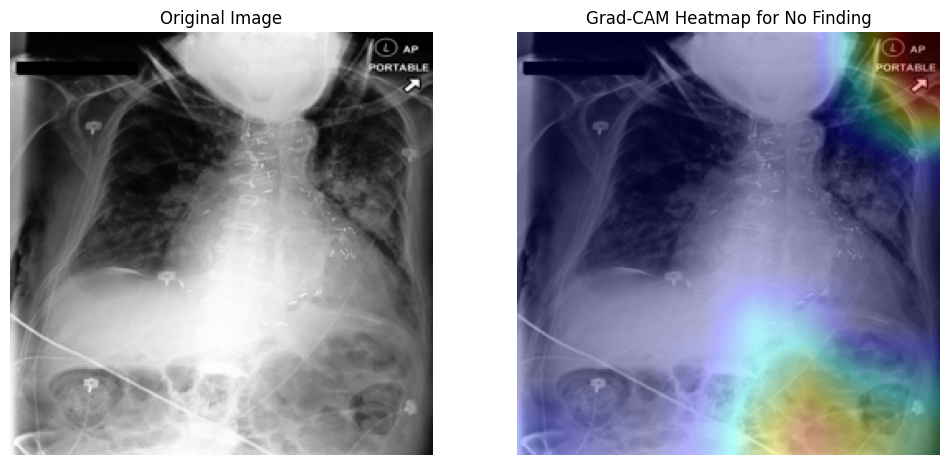

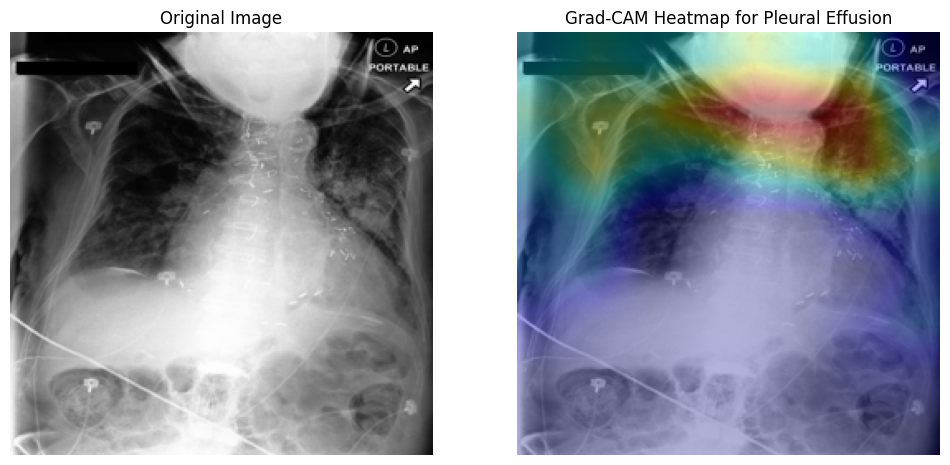

In [65]:
#This block is for manually inspection of GradGam outputs
#The results of manual expection can be found on Git page called Group_18_Testing_Document.pdf under docs


model = create_densenet121(6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loaded_model, loaded_optimizer = load_checkpoint(model, optimizer)
loaded_model.eval()
loaded_model.to(device)





# Atelectasis Testing Image 1
# p18_p19/p19/p19109135/s51197801.txt
#img = "20d9383c-3fa80c3c-94218c7f-15020bd1-e47ed769"
#img = "ae4d45fc-815b6cd8-d29c078f-ad849410-cbb8cf47"


# Atelectasis Testing Image 2
# p18_p19/p19/p19173988/s54718065.txt
#img = "52b360b9-9fe4bb09-98bffb7f-3d8e4391-863e32e3"
#img = "f556ae7b-066cd0b1-954eaf59-4c30d965-f86260ff"

# Atelectasis Testing Image 3
# p18_p19/p19/p19806884/s59414102.txt
#img = "d944bdaf-e3e6f59b-f08a84f6-86f07ba4-6c783f84"


# Atelectasis Testing Image 4
# p18_p19/p18/p18741255/s51561605.txt
#img = "34589968-8b864391-ae8fda46-91ab2791-4daf87af"


# Atelectasis Testing Image 5
# p18_p19/p19/p19229277/s53608284.txt
#img = "cf875bfb-1ea9aff7-cb1c26b0-e1598bfb-b193ff62"



# Cardiomegaly Testing Image 1
# p18_p19/p18/p18396526/s52262111.txt
#img = "3f2023b8-39fdbbf0-56b564b1-725766fd-4521856f"

# Cardiomegaly Testing Image 2
# p18_p19/p18/p18712968/s58288058.txt
#img = "01a9c196-4d0a3697-86bc7015-19c697c3-8a6fd8ea"
#img = "e29e98e9-2c21732f-ce097e4f-90427d27-6afd093c"

# Cardiomegaly Testing Image 3
# p18_p19/p19/p19807980/s57843918.txt
#img = "379d3644-53dcc490-f52c384f-4905bd21-9813c730"
#img = "2886d54b-ffa8bbe0-506cdef6-b8dd2ae4-c533ed1c"

# Cardiomegaly Testing Image 4
# p18_p19/p19/p19817306/s53766057.txt
#img = "e724f8b3-d68a8347-10f8d635-445486dd-5e1f1517"

# Cardiomegaly Testing Image 5
# p18_p19/p19/p19840732/s58791803.txt
#img = "a424fc43-96f3e8ef-34323d26-38a8ad6b-13998689"


# Consolidation Testing Image 1
#  p18_p19/p18/p18722792/s54662820.txt
#img = "1b854fc7-523ffa19-f61d6f35-a08a3097-a6286649"

# Consolidation Testing Image 2
# p18_p19/p18/p18716038/s52770632.txt
#img = "d5f42cd8-b55716cb-6df1e516-7e45a869-8d6cca95"
#img = "f97eed61-812d052b-6bf05c8b-072a8076-c83d9d3f"

# Consolidation Testing Image 3
# p18_p19/p19/p19774163/s58753570.txt
#img = "7474687d-324ff331-2e95f8d3-b7914d7c-c3d1de52"
#img = "a2212511-518016f2-5565443e-14f03252-12c867d1"

# Consolidation Testing Image 4
# p18_p19/p18/p18821140/s58495446.txt
#img = "ebc940d3-b17d2c78-26fe5f74-2031a732-6e1ccd22"

# Consolidation Testing Image 5
# p18_p19/p19/p19723160/s57120919.txt
#img = "7b385b7f-04ab764c-05c36ce0-5d9ed945-f3476595"
#img = "b3d4be3e-4e06b970-b7b96c8e-c431edfb-19aa5f41"



# Edema Testing Image 1
# p18_p19/p18/p18017335/s55311626.txt
#img = "dab94a45-c2c94579-3607bbaf-575b5829-26801e35"

# Edema Testing Image 2
# p18_p19/p18/p18031120/s55643091.txt
#img = "0a23b5f3-77bca5ef-86f4365e-cae269b8-aa497f1a"


# Edema Testing Image 3
# p18_p19/p18/p18033645/s55530651.txt
#img = "31faa2b6-3a8899c4-521ceae0-cefdb8f4-3b2f3680"


# Edema Testing Image 4
# p18_p19/p18/p18063505/s56916046.txt
#img = "ab47c784-86aedf07-753e13a9-ce23e2c6-e997843b"
#img = "28a689df-ddc46bd8-35daa760-5a5c309d-06758a2c"

# Edema Testing Image 5
# p18_p19/p18/p18108905/s50619037.txt
#img = "eeb6830f-5ab8e567-857fd6ed-5cec9b4a-177c157f"



# No Finding Testing Image 1
# p18_p19/p18/p18000291/s55388853.txt
#img = "04564240-d4e9e69c-1dd70a83-14b463cd-b7614743"
#img = "a17c02b3-7c360f2c-a07734a0-76867697-36d59d3d"
#img = "ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee"

# No Finding Testing Image 2
# p18_p19/p18/p18000379/s55947854.txt
#img = "6a9de243-1caf11ca-7f966bc6-0201c9e8-0dea45a3"
#img = "964333fa-fd1c609d-9161adb3-03ef590f-45a8a95c"

# No Finding Testing Image 3
# p18_p19/p18/p18000735/s50785186.txt
#img = "e37d4ad7-dd9760f8-a2435064-618c3875-b85fad9c"
#img = "f0d4b86f-aface71f-579cb776-b40850e6-948c4b8f"

# No Finding Testing Image 4
# p18_p19/p18/p18000818/s59355587.txt
#img = "1cf26fdd-54faeea9-6e331d75-f17c4cb9-11052ec0"
#img = "4ed3eece-cf05be86-c4f43e0d-6fe4a79b-acad7a8c"

# No Finding Testing Image 5
# p18_p19/p18/p18001129/s51043598.txt
#img = "11551ba5-8db1caaa-01677a1a-4b8297ef-10062dc7"
#img = "973cc278-9b901ebc-9e0223d1-bee44581-e8b6452f"



# Pleural Effusion Testing Image 1
# p18_p19/p18/p18003894/s56902065.txt
#img = "98b2b140-a031b7d8-a5da775a-d9d0fb3d-79dfdc83"

# Pleural Effusion Testing Image 2
# p18_p19/p18/p18019452/s57426164.txt
#img = "363ec58a-5b27a2a2-d43ad3f9-f9f36538-f898b625"

# Pleural Effusion Testing Image 3
# p18_p19/p18/p18033645/s55530651.txt
#img = "31faa2b6-3a8899c4-521ceae0-cefdb8f4-3b2f3680"

# Pleural Effusion Testing Image 4
# p18_p19/p18/p18042178/s52595621.txt
#img = "9df9e68a-f1169710-43c90f3c-402cc9f6-39d6b824"

# Pleural Effusion Testing Image 5
# p18_p19/p18/p18042178/s55414081.txt
img = "a73f67cb-036cb1ae-34b24fc2-725883fd-b5961466"


filepath = "/home/group18/Data/mimic/test/p18_p19/" + img + ".jpg"
csv_file_path = "/home/group18/Data/mimic/csv/test/p18_p19.csv"

thresholds = [0.17107886, 0.15799165, 0.03852078, 0.09797211, 0.3499906, 0.1622753]
diseaseNames = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "No Finding", "Pleural Effusion"]

print("thresholds: ", thresholds)


original_image, grad_cam_image,_ = test_single_image(filepath, csv_file_path, thresholds, model, 'cuda')

for x in range(0,6):
    plot_images(original_image, grad_cam_image[x], diseaseNames[x])

In [66]:
#This block is used to test the average run time of the model

# total_time = 0


# img = "/home/group18/Data/mimic/test/p18_p19/a73f67cb-036cb1ae-34b24fc2-725883fd-b5961466.jpg"

# #Before testing comment out print statements in run_with_no_csv and test_single_image_no_csv and load_checkpoint
# for x in range (0,20):
#     start_time = time.time()
#     run_with_no_csv(img)
#     end_time = time.time()
#     total_time += end_time - start_time

# print("Average Time in Seconds", total_time / 20)